David B:
> Okay.  A number of users in the past have asked for a way to search the archive for stars of a particular spectral type and rotational velocity.   So a) search the Bright Star Catalogue, setting spectral type to B*, and rotational velocity to “<20”.   This is the VizieR catalogue link:  http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=V/50&-out.max=50&-out.form=HTML%20Table&-out.add=_r&-out.add=_RAJ,_DEJ&-sort=_r&-oc.form=sexa.   If you execute a query with those constraints (increasing the number of returned rows to 200 perhaps) you see the results.  On the result page there is also a link to the TAP query page, http://tapvizier.u-strasbg.fr/adql/?%20V/50/catalog%20V/50/notes, but I haven’t used this.   Once a list of objects is found, query the CFHT ESPaDOnS archive for processed spectra of those targets.  I’m only interested in *i.fits products (intensity spectra vs. polarized spectra).   In most (likely all) cases there will be several or many spectra of an observed object.  If possible plot a spectral cutout of only one sample spectrum for each found object.  Use a wavelength range of 6675Å to 6682Å for now.  (I also haven’t tried cutouts for ESPaDOnS spectra…)

Also:
>Instead of the Bright Star catalogue you could query this VizieR table, J/A+A/393/897, in which case you wouldn’t have to constrain on spectral type, just vsini (rotational velocity).  (It’s mostly cooler A-type stars in this table.)
---

# Comparing Spectra
In this notebook, we will plot the spectral intensity of different stars or a particular type and rotational velocity. To fetch and query data, we will use the `astroquery` package, particularly the CADC and Vizier modules.

## Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Setup](#2.-Setup)
    * [2.1 Using pip](#2.1-Using-pip)
    * [2.2 From source](#2.2-From-source)
* [3. Querying](#3.-Querying)
* [4. Fetching Data](#4.-Fetching-Data)
* [5. Plotting Results](#5.-Plotting-Results)

## 1. Introduction
The [Bright Star Catalog](http://adsabs.harvard.edu/abs/1995yCat.5050....0H) (BSC) is an open data collection of stars brighter than magnitude 6.5 and their basic astronomical information. 

## 2. Setup
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed in two ways:

### 2.1 Using pip
The CADC module is only available with the pre-release of the astroquery module, and can be installed using the command:

```
    pip install --pre --upgrade astroquery
```

### 2.2 From source
Alternatively, you can clone and install from the source:
```
    # If you have a github account:
    git clone git@github.com:astropy/astroquery.git
    # If you do not:
    git clone https://github.com/astropy/astroquery.git
    cd astroquery
    python setup.py install
```
Note that these commands can also be done in a Jupyter notebook by either declaring the code cell a bash cell by pasting `%%bash` at the top of the cell, or preceding each line with a `!`. More information about astroquery can be found at the [astroquery github repository](https://github.com/astropy/astroquery). 

## 3. Querying
In order to get the stars that we want to look at and the spectra of those stars, we will have to do two queries: one of the Bright Star Catalog and the other of the CADC database.

### 3.1 Querying the VizieR Catalog
In order to query the BSC, we will use the [VizieR database](http://vizier.cfa.harvard.edu/) which is a library of published astronomical catalogs. Through VizieR, we can access and query the 5th Revised Ed. of the BSC. In this tutorial, we want stars of [spectral type 'B'](https://en.wikipedia.org/wiki/Stellar_classification#Class_B) and rotation velocity less than 20 km/s.

In [1]:
from astroquery.vizier import Vizier

# Get the catalog name of the 5th Revised Ed. of the Bright Star Catalog
catalog_list = Vizier.find_catalogs('Bright Star Catalogue, 5th Revised Ed.')
print({k:v.description for k,v in catalog_list.items()})
catalog_key = list(catalog_list.keys())[0]
catalog = Vizier.get_catalogs(catalog_key)
catalog_name = catalog.keys()[0]

# Increase the row limit and query the catalog
Vizier.ROW_LIMIT = 200
result = Vizier.query_constraints(catalog=catalog_name, SpType='B*', RotVel='<20', row_limit=200)
bright_star_results = result[catalog_name]
bright_star_results


{'V/50': 'Bright Star Catalogue, 5th Revised Ed. (Hoffleit+, 1991)'}


HR,Name,HD,ADS,VarID,RAJ2000,DEJ2000,Vmag,B-V,SpType,NoteFlag
,,,,,"""h:m:s""","""d:m:s""",mag,mag,,
int16,bytes10,int32,bytes5,bytes9,bytes10,bytes9,float32,float32,bytes20,bytes1
39,88Gam Peg,886,,Gam Peg,00 13 14.2,+15 11 01,2.83,-0.23,B2IV,*
62,,1279,,,00 17 09.1,+47 56 51,5.89,-0.09,B7III,
153,17Zet Cas,3360,,225,00 36 58.3,+53 53 49,3.66,-0.20,B2IV,*
208,23 Cas,4382,,,00 47 46.1,+74 50 51,5.41,-0.08,B8III,*
280,Alp Scl,5737,,359,00 58 36.4,-29 21 27,4.31,-0.16,B7IIIp,*
465,,9996,,GY And,01 38 31.7,+45 24 00,6.36,0.04,B9pCrEu,*
542,45Eps Cas,11415,,652,01 54 23.7,+63 40 12,3.38,-0.15,B3III,*
562,,11905,,,01 57 56.4,+41 41 40,6.78,-0.06,B8III,*


In [2]:
# catalog_list = Vizier.find_catalogs('J/A+A/393/897')
# # TODO: Figure out how to extend row limit??
# catalog_key = list(catalog_list.keys())[0]
# catalog = Vizier.get_catalogs(catalog_key)
# catalog_name = catalog.keys()[0]
# result = Vizier.query_constraints(catalog=catalog_name, SpType='B*', vsini='<20', row_limit=200)
# bright_star_results = result[result.keys()[0]]
# bright_star_results


### 3.2 Defining Params

Now we define the parameters needed to query the CADC data. 

In [3]:
import datetime
from astropy.coordinates import SkyCoord
from astropy import units as u

energy_bounds_ang = (6675, 6682)
ang_to_m = lambda x: x*1e-10
energy_bounds_m = (ang_to_m(energy_bounds_ang[0]), ang_to_m(energy_bounds_ang[1]))

today = datetime.datetime.now().strftime("%Y-%m-%d %X")



# For one
ra_list = bright_star_results['RAJ2000']
dec_list = bright_star_results['DEJ2000']
hd_list = bright_star_results['HD']

# Build a list of skycoords from target ra and dec
coords = [
    SkyCoord(ra, dec, frame='icrs', unit=(u.hourangle, u.deg))
    for ra, dec in zip(ra_list, dec_list)
]

# For the other
# ra_list = bright_star_results['_RA']
# dec_list = bright_star_results['_DE']
# hd_list = bright_star_results['HD']

# # Build a list of skycoords from target ra and dec
# coords = [
#     SkyCoord(ra, dec, frame='icrs', unit=u.deg)
#     for ra, dec in zip(ra_list, dec_list)
# ]


columns_subset = [
    'productID', 'collection', 'instrument_name',
    'energy_bounds_samples', 'dataProductType', 'target_name', 'dataRelease'
]


### 3.3 Querying CADC using ADQL and Loop on RA DEC

In [5]:
from astropy.table import unique, vstack
from astroquery.cadc import Cadc

cadc = Cadc()
espadons_results_list = []

for coord, hd in zip(coords, hd_list):
    query_params = {'collection': 'CFHT', 'instrument_name': 'ESPaDOnS', 'prod_id': '%i',
                    'wavelength_lower': energy_bounds_m[0],
                    'wavelength_upper': energy_bounds_m[1],
                    'hd': hd,
                    'ra': coord.ra.degree, 
                    'dec': coord.dec.degree,
                    'radius': 0.01,
                    'data_release': today}
    
    query = '''SELECT TOP 1 *, {hd} AS target_hd FROM caom2.Plane AS Plane 
    JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID 
    WHERE  ( Observation.instrument_name = '{instrument_name}'
    AND Observation.collection = '{collection}' 
    AND Plane.productID LIKE '{prod_id}' 
    AND INTERSECTS( INTERVAL( {wavelength_lower},
    {wavelength_upper} ),
    Plane.energy_bounds_samples ) = 1 
    AND Plane.dataRelease <= '{data_release}'
    AND INTERSECTS( CIRCLE('ICRS', {ra}, {dec}, {radius}), Plane.position_bounds ) = 1 
    AND ( Plane.quality_flag IS NULL OR Plane.quality_flag != 'junk' ) )'''.format(**query_params)
    job = cadc.run_query(query, 'sync')
    results = job.get_results()
    if len(results):
        espadons_results_list.append(results)
    
espadons_results = vstack(espadons_results_list)
unqiue_by_target = unique(espadons_results, keys='target_name')
unqiue_by_target[['target_hd'] + columns_subset].show_in_notebook()


idx,target_hd,productID,collection,instrument_name,energy_bounds_samples,dataProductType,target_name,dataRelease
,,,,,m,,,
0,186122,1266343i,CFHT,ESPaDOnS,[[3.698577880860001e-07 1.04809521484e-06]],spectrum,46 Aql,2012-02-28T00:00:00.000
1,11415,1168490i,CFHT,ESPaDOnS,[[3.69754608154e-07 1.04804418945e-06]],spectrum,HD 11415,2011-08-31T00:00:00.000
2,120709,794061i,CFHT,ESPaDOnS,[[3.6954989624e-07 1.04816210938e-06]],spectrum,HD 120709,2006-08-31T00:00:00.000
3,125823,1546913i,CFHT,ESPaDOnS,[[3.69794494629e-07 1.0479466552700001e-06]],spectrum,HD 125823,2013-08-31T00:00:00.000
4,141556,1690927i,CFHT,ESPaDOnS,[[3.69156585693e-07 1.04828833008e-06]],spectrum,HD 141556,2015-08-31T00:00:00.000
5,161701,1915889i,CFHT,ESPaDOnS,[[3.69411987305e-07 1.04828503418e-06]],spectrum,HD 161701,2017-08-31T00:00:00.000
6,17081,781666i,CFHT,ESPaDOnS,[[3.69087402344e-07 1.0480628662100002e-06]],spectrum,HD 17081,2006-08-31T00:00:00.000
7,216494,1646970i,CFHT,ESPaDOnS,[[3.69209106445e-07 1.0481868896500001e-06]],spectrum,HD 216494,2015-02-28T00:00:00.000
8,174933,1689959i,CFHT,ESPaDOnS,[[3.69139709473e-07 1.0482390136700002e-06]],spectrum,HD174933,2015-08-31T00:00:00.000


## 4. Fetching data

In [55]:
# TODO: Figure out the spectral cutouts
#'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3ACFHT%2F787032i.fits.gz&RUNID=vaan8ohgtovi4ezp&BAND=6.675000000000001E-7+6.682E-7'
urls = cadc.get_data_urls(unqiue_by_target)


In [56]:
from astropy.io import fits
url = urls[0]
target_list = unqiue_by_target['target_name']
data_list = []
verbose = False

for url in urls_test:
    with fits.open(url) as hdulist:
        if verbose:
            hdulist.info()
        data = hdulist[0].data
        data_list.append(data)

KeyboardInterrupt: 

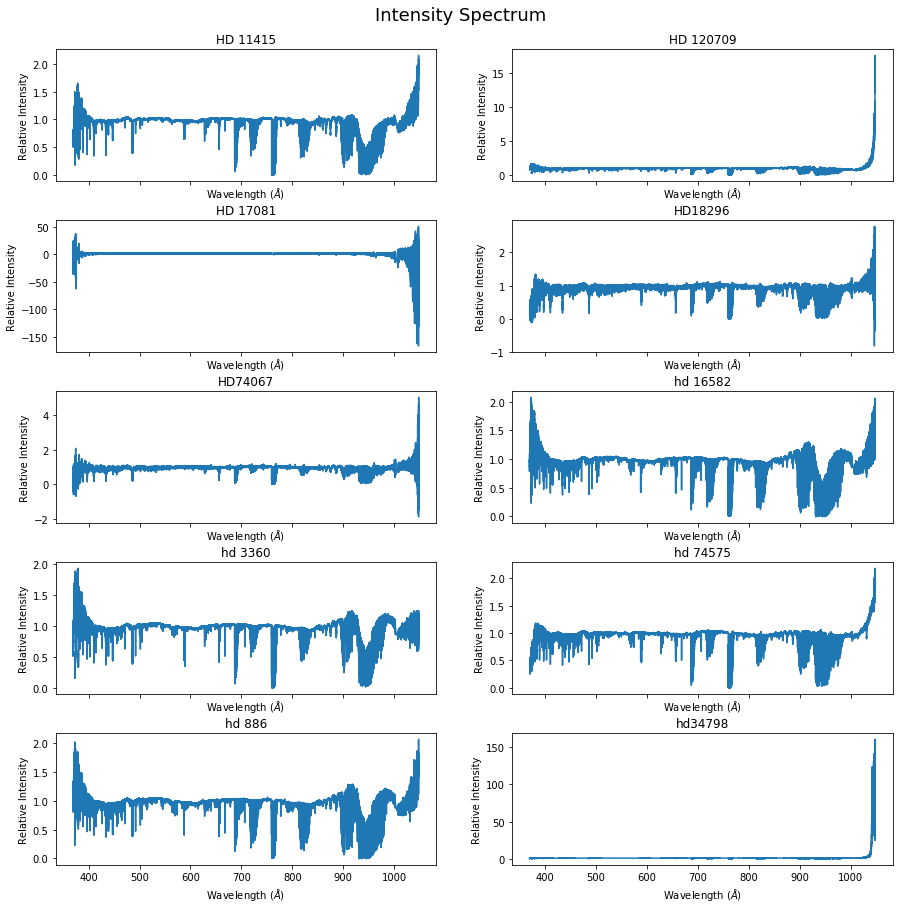

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

cols = 2
rows = math.ceil(len(data_list)/cols)
ylim = (-1, 2) 
xlim = (6675, 6682)
fig, axes = plt.subplots(rows, cols, figsize=(15, 15), sharex=True)#, sharey=True)
for data, target_name, ax in zip(data_list, target_list, axes.flatten()):
    ax.plot(data[0], data[1])
    ax.set_title(target_name)
    ax.set_xlabel(r"Wavelength ($\AA$)")
    ax.set_ylabel('Relative Intensity')
#plt.setp(axes, xlim=xlim)
fig.suptitle('Intensity Spectrum', y=0.92, fontsize=18)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
# COL1    = 'Wavelength'         / Normalized                                     
# COL2    = 'Intensity'          / Normalized                                     
# COL3    = 'ErrorBar'           / Normalized                                     
# COL4    = 'Wavelength'         / UnNormalized                                   
# COL5    = 'Intensity'          / UnNormalized                                   
# COL6    = 'ErrorBar'           / UnNormalized                                   
# COL7    = 'Wavelength'         / Normalized, no autowave correction             
# COL8    = 'Intensity'          / Normalized, no autowave correction             
# COL9    = 'ErrorBar'           / Normalized, no autowave correction             
# COL10   = 'Wavelength'         / UnNormalized, no autowave correction           
# COL11   = 'Intensity'          / UnNormalized, no autowave correction           
# COL12   = 'ErrorBar'           / UnNormalized, no autowave correction    